## Imports and dataset

In [1]:
from src.models.optimized_bnn import ClasBayesianNNVI
from src.attacks.distr_attacks_bnn_jax import mlmc_attack, fgsm_attack, kl_to_appd
from src.attacks.point_attacks_jax import attack

from src.utils import plot_ppds

import numpy as np
import pandas as pd
import jax
import jax.numpy as jnp
import numpyro
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from joblib import Parallel, delayed

/opt/anaconda3/envs/advReg/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid", palette="muted", font="serif")

sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
plt.rcParams.update({
    'axes.titlesize': 18,
    'axes.labelsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'axes.titleweight': 'bold',
    'axes.edgecolor': 'black',
    'axes.linewidth': 1,
    'grid.alpha': 0.5,
    'grid.linestyle': '--',
    'legend.fontsize': 12,
    'legend.frameon': False,
    'figure.dpi': 300,  
})

In [3]:
import numpyro
numpyro.set_host_device_count(8)

In [4]:
# set all seeds for reproducibility
seed = 42
np.random.seed(seed)

## MNIST - DE

In [5]:
# load MNIST data without tensorflow
from sklearn.datasets import fetch_openml

# Load MNIST from OpenML
mnist = fetch_openml('mnist_784', version=1)
X, y = mnist.data.values, mnist.target.values
X = jnp.array(X) / 255.0  # Normalize pixel values to [0, 1]
y = y.astype(int)
y = jax.nn.one_hot(y, 10)

# Split into training and testing datasets
X_train, X_test = X[:60000], X[60000:]
y_train, y_test = y[:60000], y[60000:]

In [6]:
modelVI = ClasBayesianNNVI(input_dim=X_train.shape[1], hidden_units=30)
try:
    modelVI.load('../src/models/weights/mnist/30bnnvi')
except FileNotFoundError:
    print('Not model found, fitting the model') 
    modelVI.fit(
        X_train, 
        jnp.argmax(y_train, axis=1), 
        num_steps=3000
    )
    modelVI.save('../src/models/weights/mnist/10bnnviflat')

In [7]:
modelVI.svi_result.keys()

dict_keys(['auto_cov_factor', 'auto_loc', 'auto_scale'])

In [8]:
# measure accuracy over the test set
y_pred = modelVI.sample_predictive_distribution(jax.random.PRNGKey(0), X_test, 1)
accuracy = (y_pred == jnp.argmax(y_test, axis=1)).mean()
print(f"Accuracy over the test set: {accuracy * 100:.2f}%")

Accuracy over the test set: 93.83%


In [9]:
# Load notMNIST data without labels
import os
from PIL import Image
import numpy as np

# Ruta de la carpeta con imágenes
folder_path = '../data/notMNIST_small'

# Lista para almacenar las imágenes
images = []

for dirpath, dirnames, filenames in os.walk(folder_path):
    for filename in filenames:
        if filename.endswith('.png'):
            img_path = os.path.join(dirpath, filename)
            img = Image.open(img_path)
            img_gray = img.convert('L')
            img_array = np.array(img_gray)
            images.append(img_array)

X_notmnist = np.array(images).reshape(-1, 28*28) / 255.0

In [10]:
def entropy(x, pred):
    pred += 1e-8
    entr = - (pred * jnp.log(pred)).sum(axis=-1) / jnp.log(2)
    return entr.mean()

In [11]:
def exp_entropy(x, y):
    return jax.nn.one_hot(y, 10).mean(axis=0)

## Baseline

100%|██████████| 50/50 [00:11<00:00,  4.48it/s]


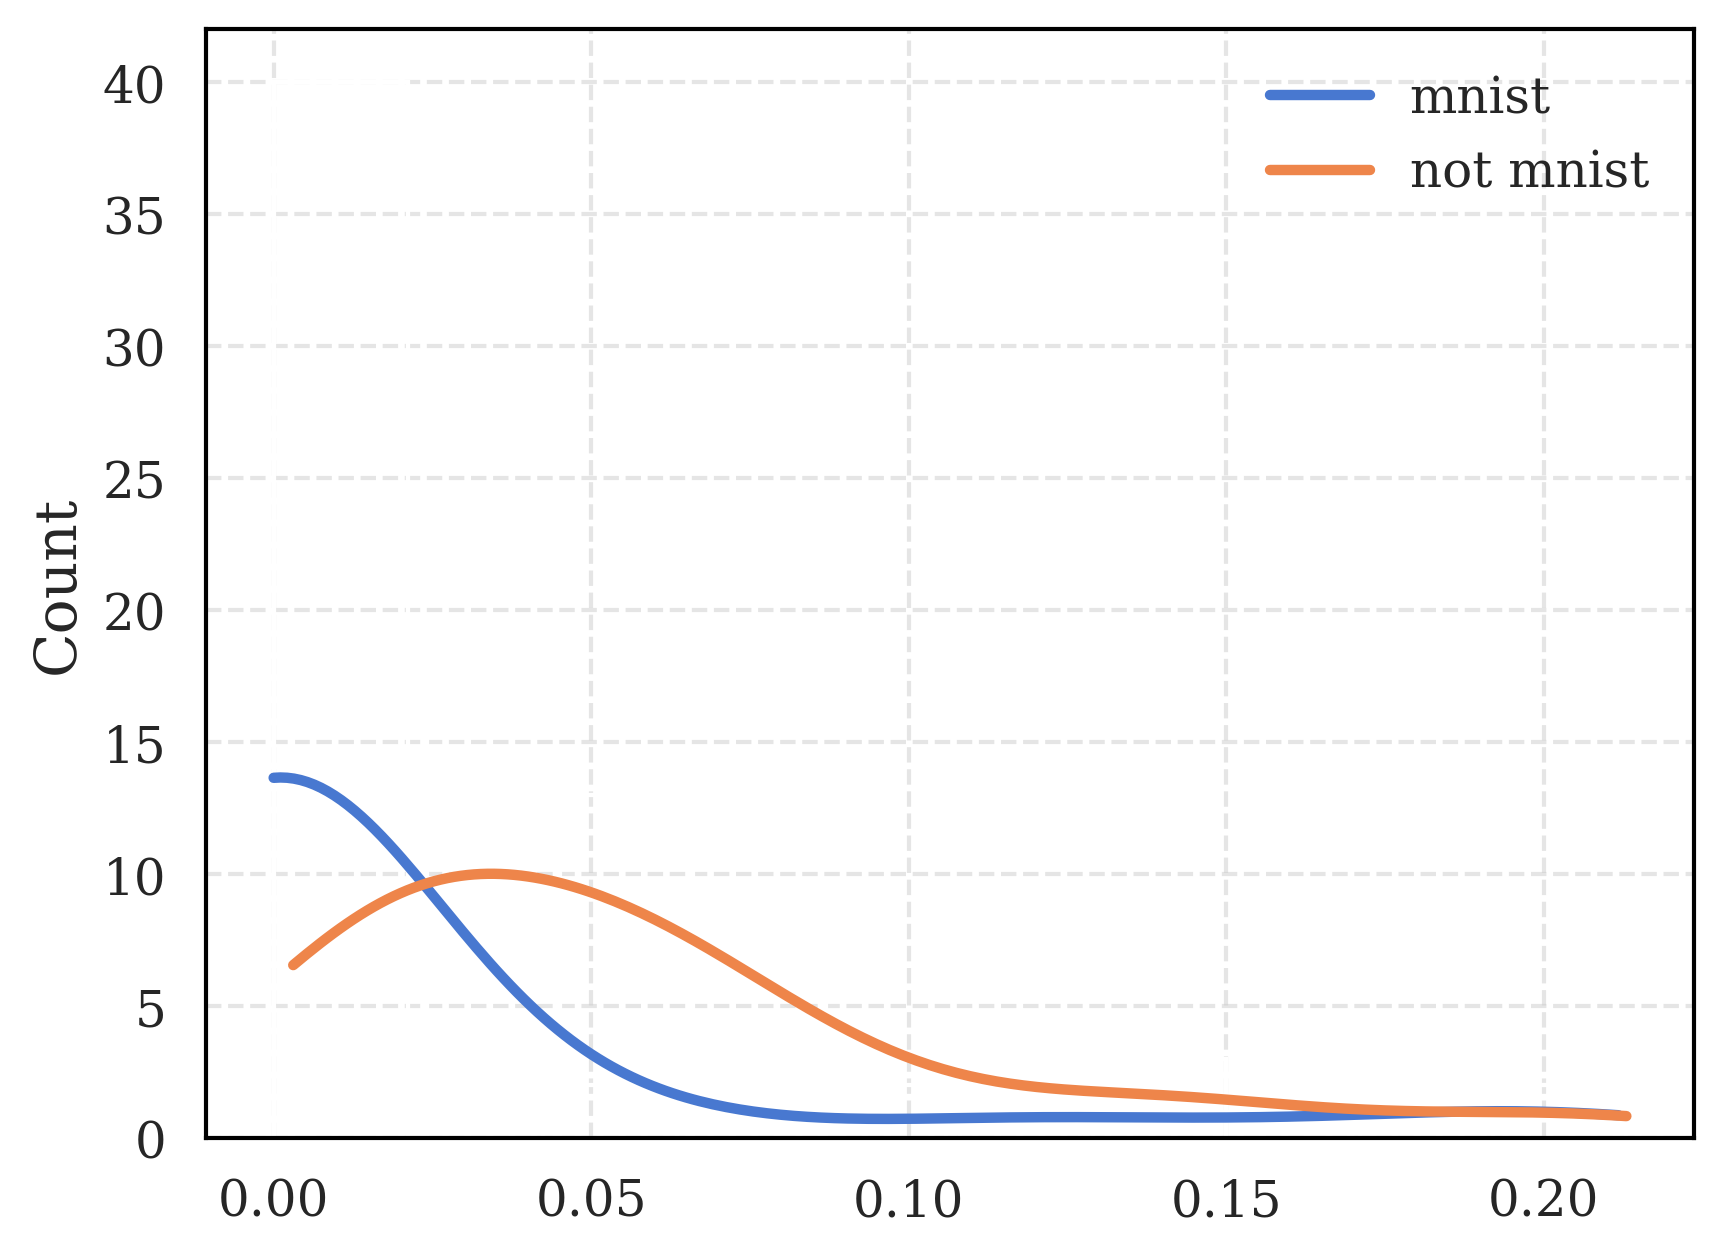

In [12]:
unattacked_entropies = []
num_points = 50
for x in tqdm(X_test[:num_points]):
    x = jax.numpy.array(x.reshape(1, -1))
    preds = modelVI.sample_predictive_distribution_probs(jax.random.PRNGKey(0), x, 20)
    unattacked_entropies.append(entropy(x, preds))

sns.histplot(jnp.array(unattacked_entropies), kde=True, bins=10, alpha=0.)
legend = ['mnist', 'not mnist']
unattacked_entropies = []
for x in tqdm(X_notmnist[:num_points]):
    x = jax.numpy.array(x.reshape(1, -1))
    preds = modelVI.sample_predictive_distribution_probs(jax.random.PRNGKey(0), x, 20)
    unattacked_entropies.append(entropy(x, preds))

sns.histplot(jnp.array(unattacked_entropies), kde=True, bins=10, alpha=0.)
plt.legend(legend)

## Point attacks

In [13]:
G = 2  # we want to rise the entropy of the predictive distribution
x = X_test[0]
eps=5
x = jax.numpy.array(x.reshape(1, -1))
x_adv_values, loss_values, func_values = attack(x, modelVI, G, func=entropy, samples_per_iteration=1000, epsilon=eps, num_iterations=1000, learning_rate=0.01)
preds = modelVI.sample_predictive_distribution_probs(jax.random.PRNGKey(0), x_adv_values[-1], 20)
print('Entropy before attack:', entropy(x, modelVI.sample_predictive_distribution_probs(jax.random.PRNGKey(0), x, 20)))
print('Entropy after attack:', entropy(x_adv_values[-1], preds))
print('Norm of the attack:', jnp.linalg.norm(x_adv_values[-1] - x))

KeyboardInterrupt: 

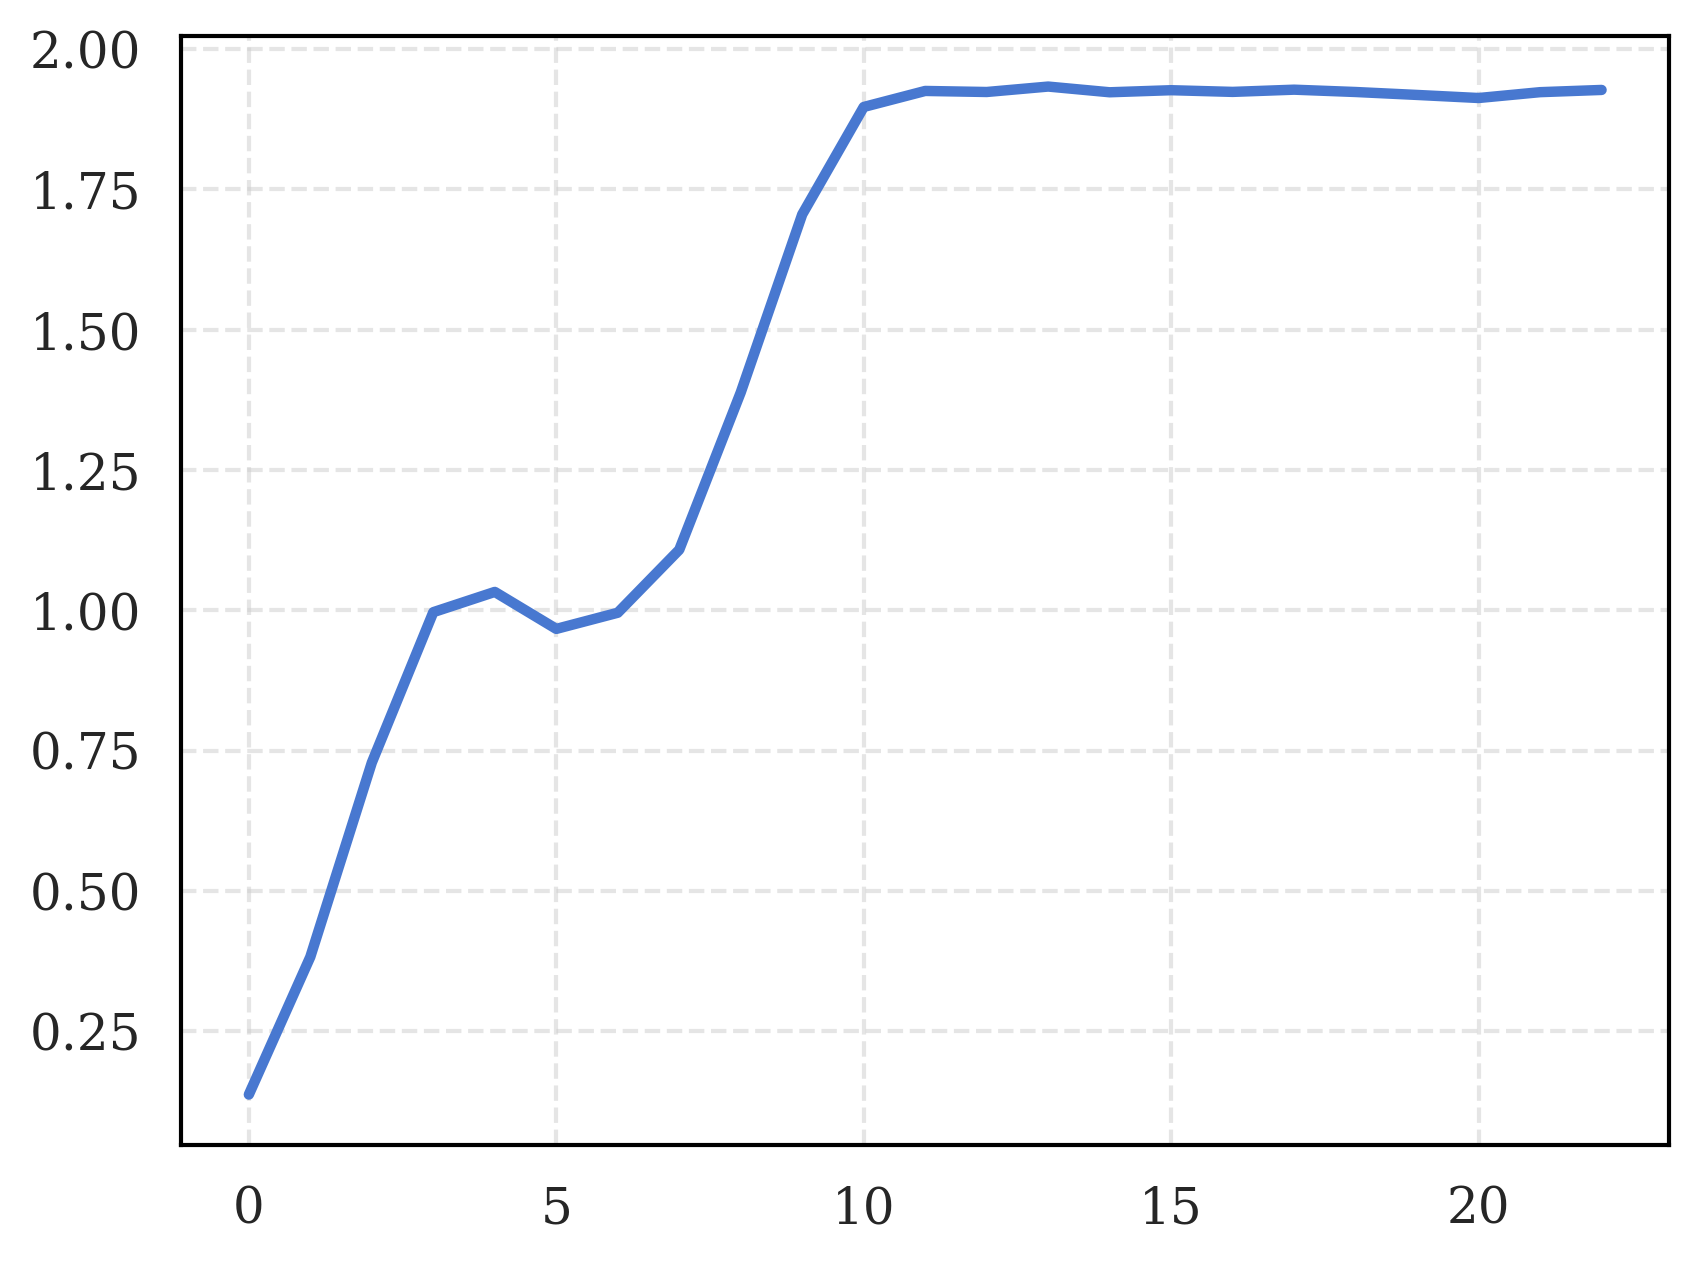

In [14]:
plt.plot(func_values)

In [14]:
G = 2  # we want to rise the entropy of the predictive distribution

def process(x, eps):
    x = jax.numpy.array(x.reshape(1, -1))
    x_adv_values, loss_values, func_values = attack(x, modelVI, G, func=entropy, samples_per_iteration=1000, epsilon=eps, num_iterations=1000, learning_rate=0.01)
    preds = modelVI.sample_predictive_distribution_probs(jax.random.PRNGKey(0), x_adv_values[-1], 20)
    return entropy(x_adv_values[-1], preds)

epsilons = [.2, .5]
num_points = 40
for eps in epsilons:
    #entropies = Parallel(n_jobs=8)(delayed(process)(x, eps) for x in tqdm(X_test[:num_points]))
    entropies = [process(x, eps) for x in tqdm(X_test[:num_points])]
    sns.histplot(jnp.array(entropies), kde=True, bins=10, alpha=0.)
    
unattacked_entropies = []
for x in tqdm(X_test[:num_points]):
    x = jax.numpy.array(x.reshape(1, -1))
    preds = modelVI.sample_predictive_distribution_probs(jax.random.PRNGKey(0), x, 20)
    unattacked_entropies.append(entropy(x, preds))

sns.histplot(jnp.array(unattacked_entropies), kde=True, bins=10, alpha=0.)
legend = ['Epsilon = ' + str(eps) for eps in epsilons] + ['Unattacked']
plt.legend(legend)

  0%|          | 0/40 [00:00<?, ?it/s]

: 

  0%|          | 0/40 [00:00<?, ?it/s]

0.0015142185
0.0027549465
0.0014917627
0.0015250436
0.0015622308
0.0057244813
0.0019139615
0.0019497443
0.005019167
0.0041472064
0.0022155684
0.0015816841
0.0018793787
0.004467078
0.0017496136
0.0020106696
0.0016923096
0.0017676873
0.0012671963
0.0016855012
0.0014685416
0.0021759951
0.0038592604
0.0010763324
0.0015154069


  2%|▎         | 1/40 [00:28<18:20, 28.22s/it]

0.0025503216
0.00057387893
0.0002367534
0.00030016576
0.00033867024
0.00015729929
0.00015850585
0.00024390254
0.00013279244
8.27102e-05
0.0001668369
0.000239657
0.00031822675
0.0001875741
0.00012637526
0.00022665692
0.00016563092
0.00030581673
2.1073143e-05
7.134154e-05
0.00030361657
8.3913044e-05
0.00014078287
0.00021455604
6.5050204e-05
8.637412e-05
0.0004582923
0.00039692523
0.00012292998


  5%|▌         | 2/40 [00:58<18:47, 29.68s/it]

0.007577449
0.0066778143
0.013976748
0.014517048
0.013917969
0.010445538
0.0065220245
0.006961464
0.012079656
0.0074470416
0.005223622
0.0073388643
0.010979974
0.008942237
0.012704888
0.006161876
0.012044542
0.007960658
0.0073841633
0.008171408
0.008192437
0.012439897
0.0062596714
0.0065480815
0.0068377466
0.007913144
0.00819586
0.008474602
0.0063997433
0.006966936
0.006325324


  8%|▊         | 3/40 [01:34<19:50, 32.17s/it]

0.0005190447
0.00040366373
0.0017598941
0.0013476601
0.0019282068
0.001376833
0.0008436393
0.0021023043
0.0014043297
0.0006692322
0.0014915913
0.00065216474
0.0005061639
0.0007812443
0.0009753407
0.0008302033
0.0018283093
0.003362857
0.0014239013
0.0008132638
0.0006448509
0.00074378663
0.00077248213
0.0022468534
0.00088380097
0.0008043076
0.0009994245
0.0016015276
0.0015683599
0.0009469604
0.0013548089
0.00051975274
0.00074402284
0.00093618594
0.00093833084
0.0012178393
0.00060282834
0.00058486196
0.0006875588
0.0014792931
0.0014397397
0.0013144055


 10%|█         | 4/40 [02:19<22:21, 37.27s/it]

0.00045001248
0.0013800738
0.0012038073
0.001341224
0.0011363061
0.0017070555
0.0005450697
0.0010709923
0.0016779755
0.0006929504
0.0008567893
0.0010891483
0.0012593812
0.00072730525
0.00083767186
0.00093903084
0.001257172
0.0013698069
0.0007454499
0.0007474488
0.00056008203
0.00071623456
0.00048916915
0.0013285615
0.002331778
0.0011189566
0.0012055124
0.00064134714
0.00037575216
0.0005722315
0.0004753023
0.0009944228
0.00069880026
0.001429433
0.001711337
0.0007511909
0.0007882662
0.00074253697
0.0011045226


 12%|█▎        | 5/40 [03:02<22:59, 39.43s/it]

0.0053647575
0.004033242
0.0074651306
0.0032300784
0.002956454
0.006127319
0.004671088
0.005185899
0.005340638
0.005263355
0.00411757
0.009122715
0.003172691
0.007926187
0.0035603233
0.0028720957
0.0028161916
0.011666944
0.0052717575
0.006713206
0.0026012757
0.004176696
0.0045370907
0.0031624564
0.0016295351
0.0021484368
0.0045499997
0.0029151984
0.0061995387
0.0023491727
0.002478892
0.001612406
0.0033450872
0.0021410394
0.0028697664
0.0046949135
0.0045194486
0.0031563533
0.0088845
0.004305751
0.0028522327
0.010735493


 15%|█▌        | 6/40 [03:48<23:37, 41.70s/it]

0.00038053378
0.00094595156
0.00038933544
0.00021651841
0.0003375003
0.00021358122
0.00011116379
0.00011341623
0.00044830263
0.0001912109
0.000106874686
0.000113937385
0.00018533178
9.8966964e-05
0.0001850069
0.00021506479
0.00028175165
0.00027206948
0.0001607665
0.00016848982
0.000211822
0.00032502145


 18%|█▊        | 7/40 [04:11<19:30, 35.47s/it]

0.0005190447
0.00040366373
0.0017598941
0.0013476601
0.0019282068
0.001376833
0.0008436393
0.0021023043
0.0014043297
0.0006692322
0.0014915913
0.00065216474
0.0005061639
0.0007812443
0.0009753407
0.0008302033
0.0018283093
0.003362857
0.0014239013
0.0008132638
0.0006448509
0.00074378663
0.00077248213
0.0022468534
0.00088380097
0.0008043076
0.0009994245
0.0016015276
0.0015683599
0.0009469604
0.0013548089
0.00051975274
0.00074402284
0.00093618594
0.00093833084
0.0012178393
0.00060282834
0.00058486196
0.0006875588
0.0014792931
0.0014397397
0.0013144055


 20%|██        | 8/40 [04:55<20:29, 38.44s/it]

0.001407279
0.0046703927
0.008127865
0.0024049068
0.0020021633
0.0017370081
0.0023018934
0.00083319563
0.001716938
0.0009909245
0.0021476224
0.001323207
0.0016290401
0.0016340148
0.0022237888
0.0007374248
0.0026030778
0.0014044979


 22%|██▎       | 9/40 [05:14<16:38, 32.22s/it]

0.003713695
0.0022299045
0.0032278143
0.0021590583
0.0031449466
0.0028304486
0.008958213
0.008886432
0.007199369
0.00480154
0.0033472956
0.002453162
0.003315069
0.0043474194


 25%|██▌       | 10/40 [05:28<13:21, 26.72s/it]

1.6010395e-05
2.5120599e-08
2.7502289e-05
3.4636538e-05
0.0001351822
3.0160485e-05
6.916915e-06
3.478309e-06
4.561914e-05
8.751633e-06
1.2389528e-07
3.9825307e-05


 28%|██▊       | 11/40 [05:41<10:46, 22.28s/it]

3.7089187e-05
8.768118e-05
1.7906363e-05
1.6036982e-05
4.1217696e-05
7.330848e-06
5.6233243e-06
1.4643028e-05
1.8284194e-05
7.354672e-06
8.009825e-06
5.1959036e-05
4.51978e-08
3.787627e-06
6.316142e-06
7.5432013e-06
1.258074e-05
6.093545e-08
1.7000315e-06
7.017759e-06
4.8013142e-05
5.1062823e-05
1.1025476e-07
2.5118896e-05
4.0267263e-05
2.5290907e-05
2.4833256e-05
8.281427e-05


 30%|███       | 12/40 [06:11<11:33, 24.78s/it]

0.0037595534
0.009735279
0.019076418
0.02241648
0.016444365
0.0064594774
0.010482111
0.013661559
0.008066387
0.011980042
0.011188787
0.01439604
0.0053591635
0.0076013682
0.006235841
0.0060128886
0.0063045733
0.020325461
0.010515971
0.014750315
0.00912091
0.005251275
0.012616734


 32%|███▎      | 13/40 [06:34<10:57, 24.35s/it]

0.0034169124
0.005390051
0.006546989
0.002709018
0.0035392684
0.0020290245
0.0033369642
0.005827796
0.004090075
0.008628298
0.004014356
0.0026968494
0.010212924
0.0033243583
0.0047424757
0.011622186


 35%|███▌      | 14/40 [06:53<09:47, 22.58s/it]

0.0023685126
0.0046357284
0.0021174615
0.002267479
0.0031102921
0.0021098785
0.004496345
0.0034459967
0.0029680585
0.0017586633
0.0022891562
0.001794123
0.002492361
0.0025369388
0.0013633956
0.0020386684
0.002393481
0.00105587
0.0009710093
0.0007041575
0.001611275
0.0015826509
0.0016375858
0.0010194392
0.0018443967
0.0007351698
0.0009280384
0.0036801267
0.002975866
0.0063624014


 38%|███▊      | 15/40 [07:23<10:22, 24.89s/it]

0.004814131
0.012593713
0.0051835137
0.0047380435
0.006547726
0.0027358271
0.0011917339
0.0016813311
0.00094119034
0.001977174
0.002410944
0.0028342917
0.00092876324
0.0028720535
0.0009866137
0.0016704054
0.0022188264
0.002424635
0.0047217356
0.0009472911
0.0030146805
0.00082972145
0.002013002
0.002120175
0.0020300427
0.0013695536
0.0032589396
0.0011394667
0.0036368112
0.0009082216
0.0013294604
0.0019499364
0.002527713
0.0026590487
0.0018187998
0.0022954945
0.0028924742
0.0028180217
0.0015227952
0.0028603494


 40%|████      | 16/40 [08:06<12:07, 30.29s/it]

0.0005190447
0.00040366373
0.0017598941
0.0013476601
0.0019282068
0.001376833
0.0008436393
0.0021023043
0.0014043297
0.0006692322
0.0014915913
0.00065216474
0.0005061639
0.0007812443
0.0009753407
0.0008302033
0.0018283093
0.003362857
0.0014239013
0.0008132638
0.0006448509
0.00074378663
0.00077248213
0.0022468534
0.00088380097
0.0008043076
0.0009994245
0.0016015276
0.0015683599
0.0009469604
0.0013548089
0.00051975274
0.00074402284
0.00093618594
0.00093833084
0.0012178393
0.00060282834
0.00058486196
0.0006875588
0.0014792931
0.0014397397
0.0013144055


 42%|████▎     | 17/40 [08:49<13:05, 34.15s/it]

0.0005335276
0.00088694895
0.0008727013
0.0007621034
0.00044070472
0.00094842183
0.0008555289
0.0023049966
0.0007092395
0.00071077625
0.0017273717
0.0008066
0.0007137562
0.00061398535
0.0011436392
0.001288632
0.00076294155
0.0005448509
0.0009261257
0.000682256


 45%|████▌     | 18/40 [09:12<11:16, 30.73s/it]

0.00028653417
0.0010235041
0.0005646891
0.0003585588
0.00010581458
0.00013270522
0.00031213037
0.00011487088
0.0005626445
0.00018287996
0.00034890304
0.0003902392
0.00019361028
0.00027403852
0.0004369266
0.00045665406
0.00032543138
0.000118263146


 48%|████▊     | 19/40 [09:31<09:29, 27.10s/it]

0.004780302
0.0040422794
0.009923478
0.0067648008
0.0024516175
0.008920137
0.0023156742
0.0069107977
0.002520683
0.0039423304
0.0055128043
0.0031687529
0.0026979856
0.0041227723
0.00301434
0.0049024564
0.0029509638
0.003963328
0.0070568607
0.0035427813
0.0025866954
0.0026064077
0.002281434
0.004207444
0.0035629682
0.0020393287
0.0051079076
0.0045475382
0.0033897096
0.0038324357
0.0016126588
0.0014105439
0.0030893066
0.0027952052
0.0038930182
0.005227673
0.003513668
0.0037449605
0.0034718
0.0026143526
0.0039032125
0.0014691636
0.0032351885
0.0025238798
0.004676762
0.004183704


 50%|█████     | 20/40 [10:20<11:19, 33.95s/it]

0.0005190447
0.00040366373
0.0017598941
0.0013476601
0.0019282068
0.001376833
0.0008436393
0.0021023043
0.0014043297
0.0006692322
0.0014915913
0.00065216474
0.0005061639
0.0007812443
0.0009753407
0.0008302033
0.0018283093
0.003362857
0.0014239013
0.0008132638
0.0006448509
0.00074378663
0.00077248213
0.0022468534
0.00088380097
0.0008043076
0.0009994245
0.0016015276
0.0015683599
0.0009469604
0.0013548089
0.00051975274
0.00074402284
0.00093618594
0.00093833084
0.0012178393
0.00060282834
0.00058486196
0.0006875588
0.0014792931
0.0014397397
0.0013144055


 52%|█████▎    | 21/40 [11:05<11:43, 37.05s/it]

0.0011299865
0.003495297
0.004243646
0.0035218573
0.0016708546
0.0028563277
0.0053485353
0.0019079017
0.001512103
0.0011988414
0.0047600847
0.0010018654
0.0016789905
0.001889506
0.0016851162
0.0016097421
0.0021682084


 55%|█████▌    | 22/40 [11:25<09:36, 32.02s/it]

0.0008122243
0.0015478709
0.0016064588
0.0011962171
0.0037780218
0.00074929465
0.0006632635
0.001723087
0.0014109927
0.0009805787
0.00164624
0.0013087052
0.0007741009
0.001223512
0.0009572639
0.0007801874
0.0008621575
0.0016172958
0.001089522
0.000740777
0.0008038185
0.00075200875
0.0006344258
0.0014013194
0.0011338517
0.00095557264
0.0006315566
0.00058983837
0.00076529087
0.0006747433
0.00033956234
0.0005318471
0.0007265873
0.0009752231
0.0011206976
0.0009307621
0.00074505527
0.0016800809
0.000777699
0.0011486606
0.0009670499
0.0023495546


 57%|█████▊    | 23/40 [12:11<10:12, 36.06s/it]

0.00037584497
0.001104339
0.0009467137
0.0010565156
0.0009205773
0.0008863695
0.0009626634
0.0032321739
0.0023700816
0.0011947798
0.0007481367
0.00036338854
0.0004985399
0.00070852094
0.00038741788
0.0017818573
0.001032214
0.00086586486
0.0007379235
0.0004882281


 60%|██████    | 24/40 [12:34<08:37, 32.36s/it]

2.9550209e-05
0.0011476148
0.0019210125
0.00047203613
0.00069471996
0.0017823722
0.00055368047
0.00038616333
0.00033527563
0.00023393548
0.00029133572
0.0005261388
0.00014051469
0.00029707912
0.00069357327
0.00043283863
0.00047184675
0.0007525389
0.00022821236
0.00023578411
0.000589994


 62%|██████▎   | 25/40 [12:56<07:16, 29.09s/it]

0.0009382964
0.0010502632
0.0007652187
0.0016284963
0.0013326767
0.00089817063
0.0008562462
0.001257061
0.0010277868
0.001306073
0.0009626533
0.00049991
0.0010298142
0.00043775927
0.0018358692
0.0011172638
0.0003995085
0.00095218286


 65%|██████▌   | 26/40 [13:14<06:02, 25.87s/it]

0.00088554074
0.0007393556
0.00092927995
0.00083285087
0.0005310663
0.00067478116
0.00032711244
0.00053763523
0.0009159846
0.00040099432
0.0011627757
0.0012374689
0.0007215273
0.0010293743
0.0005590645
0.0009061549
0.00086000917
0.00042775838
0.0005665742
0.0007005808
0.0005866667
0.0007938615
0.00048055185
0.00063439074
0.00052636175
0.00040456554
0.0005530116
0.0007556983
0.00022429704
0.0004752334
0.00048332984
0.0005262726
0.00028340696
0.00077055313
0.00057458394


 68%|██████▊   | 27/40 [13:53<06:26, 29.76s/it]

0.0005190447
0.00040366373
0.0017598941
0.0013476601
0.0019282068
0.001376833
0.0008436393
0.0021023043
0.0014043297
0.0006692322
0.0014915913
0.00065216474
0.0005061639
0.0007812443
0.0009753407
0.0008302033
0.0018283093
0.003362857
0.0014239013
0.0008132638
0.0006448509
0.00074378663
0.00077248213
0.0022468534
0.00088380097
0.0008043076
0.0009994245
0.0016015276
0.0015683599
0.0009469604
0.0013548089
0.00051975274
0.00074402284
0.00093618594
0.00093833084
0.0012178393
0.00060282834
0.00058486196
0.0006875588
0.0014792931
0.0014397397
0.0013144055


 70%|███████   | 28/40 [14:41<07:03, 35.32s/it]

0.004704032
0.0064317854
0.002390159
0.0023104677
0.0014766037
0.0012723714
0.0040381076
0.007606611
0.0009814985
0.0020445387
0.002119217
0.003367427
0.0020533786
0.0036821128
0.0025653094
0.0014504744
0.00240433
0.0026245588
0.0012968251
0.00088321517
0.0040161894
0.0014399108
0.0014206109
0.0011905944
0.0017522196
0.0024261684
0.0033997826
0.0012016933
0.004248977
0.0016954063
0.0009273093
0.0024632132
0.0024785965
0.001763266
0.0023097557
0.0024602716
0.0008726004
0.00093208393
0.0034745426
0.0008503229
0.0012602217
0.0022530984
0.0019109237
0.004083216


 72%|███████▎  | 29/40 [15:29<07:11, 39.19s/it]

0.00047903965
0.0012664425
0.00057721237
0.0004707273
0.00045889293
0.0008069481
0.00018707143
0.0002782293
0.0002897917
0.00031300902
0.0010753599
0.00049579144
0.00029700273
0.0007572388
0.00031165834
0.00042410687
0.00073841587
0.00024915987
0.0002225593
0.0002970477
0.00046494883


 75%|███████▌  | 30/40 [15:54<05:48, 34.85s/it]

0.00021041944
0.00012045873
1.7643475e-05
8.571968e-05
5.1250913e-06
0.0001453064
3.3424443e-05
2.4473198e-05
1.3373787e-05
3.7618993e-06
6.261246e-05
3.4914086e-05
2.7775553e-05
5.1304945e-05
6.6029706e-06
2.824264e-05
2.1325832e-05
1.123276e-05
1.863945e-05
1.4731861e-05


 78%|███████▊  | 31/40 [16:15<04:37, 30.79s/it]

0.00041615858
0.0012975282
0.0014646536
0.0023289332
0.0012624378
0.00143853
0.00071319536
0.0016289575
0.0012609366
0.00074941
0.00066250755
0.00091523275
0.0008651673
0.0006823316
0.00065418705
0.0012052516
0.0006453788
0.00081685255
0.0017039552
0.0007783871


 80%|████████  | 32/40 [16:37<03:43, 27.99s/it]

0.00019203068
4.8992988e-05
4.5444467e-05
2.3836095e-05
8.8929355e-06
1.4022416e-05
5.4920783e-06
1.5161309e-05
2.8933799e-05
3.6124657e-05
1.5892561e-10
5.8893743e-06
5.0347445e-11
5.7262623e-05
3.637467e-06
5.6403933e-06
9.337474e-06
1.5557632e-06
4.2899483e-06
2.6901298e-05
6.42853e-06
4.2912838e-05
1.3682552e-05


 82%|████████▎ | 33/40 [17:04<03:13, 27.67s/it]

0.0010326884
0.002500354
0.0008682029
0.00082159246
0.00244724
0.0011323136
0.0020136589
0.0021060142
0.0016668305
0.0016957588
0.0011546047
0.0038460006
0.002635262
0.002986845
0.001680081
0.0007154604
0.00096445327
0.0009734419
0.0006565988
0.00069845177
0.0007609059
0.0009852917
0.0018665383


 85%|████████▌ | 34/40 [17:28<02:39, 26.61s/it]

0.0005190447
0.00040366373
0.0017598941
0.0013476601
0.0019282068
0.001376833
0.0008436393
0.0021023043
0.0014043297
0.0006692322
0.0014915913
0.00065216474
0.0005061639
0.0007812443
0.0009753407
0.0008302033
0.0018283093
0.003362857
0.0014239013
0.0008132638
0.0006448509
0.00074378663
0.00077248213
0.0022468534
0.00088380097
0.0008043076
0.0009994245
0.0016015276
0.0015683599
0.0009469604
0.0013548089
0.00051975274
0.00074402284
0.00093618594
0.00093833084
0.0012178393
0.00060282834
0.00058486196
0.0006875588
0.0014792931
0.0014397397
0.0013144055


 88%|████████▊ | 35/40 [18:14<02:42, 32.44s/it]

0.0016609455
0.00092785875
0.0009374019
0.00095646706
0.000562513
0.00094694167
0.0016384219
0.00086839753
0.0014095233
0.0007693099
0.0007105226
0.0005975731
0.0005947464
0.00094921817
0.0006678497


 90%|█████████ | 36/40 [18:30<01:49, 27.47s/it]

0.0029740538
0.0074575045
0.00432459
0.00376245
0.0052818297
0.0033836795
0.0036571242
0.0046612807
0.0026028403
0.0029853475
0.002933907
0.0039752754
0.0044190288
0.0027803467


 92%|█████████▎| 37/40 [18:45<01:10, 23.62s/it]

0.0030964375
0.001800762
0.0017847612
0.00285346
0.0024025682
0.0021334898
0.0023570356
0.0009306561
0.0022405956
0.0012004782
0.0013822325
0.001437471
0.00081068854
0.0009325285
0.0023024275
0.0013323352
0.0010545913
0.0025867403
0.0024006928
0.0015203429
0.0018910597
0.0009455152
0.0014907268
0.0018400645


 95%|█████████▌| 38/40 [19:11<00:49, 24.53s/it]

0.0017383157
0.002929154
0.00397519
0.006225733
0.0034048837
0.002646595
0.00097216415
0.0013226751
0.0016883528
0.0010574404
0.0014212574
0.0013238457
0.004029896
0.0015838525
0.0014378498
0.0010525576
0.0014645279
0.0011009127
0.0017136681
0.0018896821


 98%|█████████▊| 39/40 [19:32<00:23, 23.42s/it]

0.0022693689
0.005480121
0.005888589
0.0060450104
0.002829523
0.0031897335
0.0031355738
0.0032258956
0.0013690866
0.0027776216
0.0019139821
0.0068035116
0.0015884367
0.001453094
0.0015537173
0.0019108324
0.0013677309
0.0015605437
0.001576868
0.0042758817
0.0012468349
0.0015337894
0.0015925915
0.0015068416
0.0009390761
0.0020343577
0.0027264836
0.0033403803
0.0013342609
0.00095736666
0.002194906


  0%|          | 0/40 [00:00<?, ?it/s]

0.0015142185
0.003622528
0.0034602962
0.0014709828
0.0027792966
0.001577229
0.0016566192
0.0015557363
0.0015483673
0.0016326479
0.0023059861
0.0012993404
0.0018615483
0.0012998579
0.0017325621
0.0014518062
0.0013390298
0.0012068219
0.00094013184
0.0016808973
0.0010522202
0.0013631193
0.001120889
0.0009861819
0.0011068666
0.001929132
0.000997339
0.0008474779
0.0012350397
0.0008671958
0.001519251
0.0011932537
0.0007137762
0.0007863459
0.0012915982
0.0018668716
0.00075833645
0.00086266926
0.0010889356
0.00085230696


  2%|▎         | 1/40 [00:43<28:26, 43.75s/it]

0.0025503216
0.0005848109
0.00015934053
0.00019138053
0.00019028544
0.00029648392
3.6414185e-05
3.5940095e-05
1.09238545e-05
3.6467307e-05
3.1175197e-05
6.29976e-07
1.0476315e-05
2.564383e-05
9.397266e-09
1.1222124e-05
3.728039e-09
6.188286e-06
3.0345802e-05
5.073583e-06
2.8796929e-05
2.2449625e-05
2.4504558e-05
5.1449068e-05
1.8513181e-05
3.0495361e-05
1.334912e-05


  5%|▌         | 2/40 [01:13<22:39, 35.77s/it]

0.007577449
0.01202926
0.012339801
0.0123058595
0.009485465
0.0059468374
0.009187236
0.0058940616
0.011417588
0.006883706
0.0051871887
0.0027940448
0.0023657044
0.007670362
0.004472996
0.0025332228
0.0038310606
0.0021910223
0.0024975499
0.003029966
0.0024387196
0.0020746826
0.0020492512
0.0009201064
0.0012877285
0.0067586955
0.0035573186


  8%|▊         | 3/40 [01:42<19:53, 32.27s/it]

0.0005190447
0.0005042456
0.0022792174
0.00082542514
0.00037041685
0.00086628005
0.0010147667
0.0008074071
0.000757565
0.0010558148
0.0008879038
0.00088088016
0.0016517238
0.0019004762
0.0005851447
0.0003945905
0.0009588375
0.00051538605
0.0006301892
0.00034696178
0.00032091746
0.0007821002
0.0004881631
0.0002857325
0.0002883413
0.00065947085
0.000591633
0.00044513232
0.0003788813
0.00035058826
0.00044984164


 10%|█         | 4/40 [02:14<19:17, 32.16s/it]

0.00045001248
0.0014676203
0.0011859594
0.001672953
0.0015553867
0.000936241
0.0010620051
0.0010329941
0.0016560798
0.00045831507
0.0005933398
0.0008177084
0.0005384595
0.0006311439
0.0005707822
0.00037900324
0.0005862542
0.00058589684
0.0009739249
0.0009227318
0.0005755654
0.00047588203
0.0004625886
0.0005381549
0.00036040723
0.0008418743


 12%|█▎        | 5/40 [02:42<18:03, 30.96s/it]

0.0053647575
0.0040642605
0.0028990356
0.0036780674
0.005851571
0.0066564037
0.005385263
0.007418996
0.004598642
0.0040487507
0.004736865


 15%|█▌        | 6/40 [02:54<13:47, 24.33s/it]

0.00038053378
0.00040554875
0.00017122451
0.00010373381
0.00011181504
1.6465936e-05
3.8886967e-05
0.0003708354
7.443257e-05
7.010021e-06
2.887002e-05
3.817792e-05
4.97324e-05
8.854635e-06
6.1876126e-05
5.861633e-06
7.311491e-06
1.0165224e-05
4.3440552e-05
2.2425102e-05


 18%|█▊        | 7/40 [03:15<12:44, 23.18s/it]

0.0005190447
0.0005042456
0.0022792174
0.00082542514
0.00037041685
0.00086628005
0.0010147667
0.0008074071
0.000757565
0.0010558148
0.0008879038
0.00088088016
0.0016517238
0.0019004762
0.0005851447
0.0003945905
0.0009588375
0.00051538605
0.0006301892
0.00034696178
0.00032091746
0.0007821002
0.0004881631
0.0002857325
0.0002883413
0.00065947085
0.000591633
0.00044513232
0.0003788813
0.00035058826
0.00044984164


 20%|██        | 8/40 [03:48<14:08, 26.52s/it]

0.001407279
0.0029921602
0.0016735515
0.0014010158
0.0009295072
0.0025422636
0.00089857314
0.00059938256
0.00078741356
0.0004939127
0.0015813891
0.00061166607
0.00057758717
0.0019064521
0.0009968356
0.00053548755
0.00012950045
0.00020500312
0.00034504724
0.00025419268
0.00047248433
0.00012400078
6.573442e-05
8.4956795e-05
9.7961514e-05
0.00020492129
0.00016241198
5.109482e-05
6.7046705e-05
1.8117737e-05
1.6568983e-05
0.00016226406
5.5755205e-05
3.4383207e-05
7.425804e-05
4.154226e-05
8.971208e-05
9.00814e-05
8.613801e-05
4.0564657e-05
6.469026e-05


 22%|██▎       | 9/40 [04:31<16:23, 31.71s/it]

0.003713695
0.0023454996
0.009877285
0.0029954407
0.0013062129
0.0009790864
0.0017178813
0.00067345577
0.00070509466
0.000970866
0.00094072416
0.00068877253
0.0010326037
0.0003040034
0.000891819
0.00042448117
0.00036653932
0.0012568597
0.0012389173
0.0004912981
0.00056163355
0.00052602007
0.0007889059
0.0014321274


 25%|██▌       | 10/40 [04:56<14:44, 29.47s/it]

1.6010395e-05
7.7624757e-10
2.587761e-05
9.43647e-07
2.059718e-06
2.5225836e-06
2.3432284e-07
3.0165534e-08
2.7507424e-06
6.7797568e-09
2.5824194e-08
2.160325e-06
1.3068614e-12
7.678617e-06
7.805113e-06
1.2164444e-06
5.490876e-07
6.153798e-06
4.684754e-09
6.311857e-11
1.3000132e-10
3.4928004e-13
1.6719804e-09
4.0829699e-13
9.447878e-10
1.317609e-11
3.5344816e-16
1.6835547e-11
2.1814573e-14
3.266632e-13
3.1482883e-10
1.0901408e-15
5.4626772e-11
3.9406787e-06
1.1989749e-13
2.530128e-09
3.201945e-11


 28%|██▊       | 11/40 [05:36<15:45, 32.60s/it]

3.7089187e-05
1.1735498e-05
3.476365e-05
1.27847525e-05
1.0972837e-05
4.6009386e-06
8.470082e-06
1.1242009e-05
1.967141e-05
1.6884497e-06
2.2560027e-05
4.880915e-06
1.9988002e-08
1.5835196e-05
3.946527e-05
2.4331945e-05
2.5808393e-07
3.637747e-08
3.2780135e-05
6.8756446e-05
6.3770385e-05
3.6276477e-05
1.9198695e-05
4.2752625e-05
2.7280526e-05
2.5734536e-05
1.9045774e-06
6.6133025e-06


 30%|███       | 12/40 [06:04<14:34, 31.23s/it]

0.0037595534
0.011201667
0.0046529933
0.0071009886
0.0039953017
0.0018704749
0.0031180128
0.0014692289
0.0012944097
0.0020825518
0.0014964448
0.0019076371
0.0015739446
0.0006625762
0.0016005592
0.0023876668
0.0014124427
0.0010479372
0.0010446615
0.0016012049
0.0034624941
0.0013343319
0.0017081534
0.002272599
0.002491296
0.0021166345
0.002688472
0.0022724473


 32%|███▎      | 13/40 [06:32<13:41, 30.41s/it]

0.0034169124
0.007222585
0.0075513204
0.0034072013
0.004708945
0.0023266773
0.0050551863
0.005159444
0.005719915
0.0053540403
0.0025597569
0.008614312
0.0021673169
0.0015949102
0.0054537193
0.001606468
0.0034554468
0.0029743325
0.0027710937
0.003176277
0.0016874044
0.0014381487
0.0011509749
0.0018154819
0.0010293705
0.0044022626
0.0047275247
0.0017042542
0.001860687
0.0037584421
0.0035107266
0.0010109707
0.0009064291
0.0008428952
0.0010912386
0.0017171988
0.0011871222
0.0013836884
0.0021387355
0.0015077573
0.0020125443
0.0020483332
0.0022516148
0.0012051022


 35%|███▌      | 14/40 [07:20<15:28, 35.70s/it]

0.0023685126
0.006327698
0.0024607263
0.0008952804
0.00063586305
0.0006221603
0.00022078448
0.00032480163
0.00018104028
0.00011389333
0.00025612558
9.6202326e-05
6.324727e-05
0.00030607337
0.00020252142
0.00027825581
9.5207804e-05
0.00019473073
0.00017202526
0.0002437172
0.00036739657
0.00012095644
0.00045575743


 38%|███▊      | 15/40 [07:45<13:32, 32.51s/it]

0.004814131
0.012661928
0.0015595634
0.0010114363
0.00027586232
9.26324e-05
0.000120375116
0.00016804611
0.0001630275
0.0001613715
0.000103880535
4.4420856e-05
0.00018430325
6.252496e-08
2.2590935e-05
5.8570593e-05
7.90855e-05
8.9868576e-05
0.000111417765
3.6147205e-05
2.1700503e-06
3.466481e-05
8.599813e-05
2.523845e-05


 40%|████      | 16/40 [08:10<12:05, 30.22s/it]

0.0005190447
0.0005042456
0.0022792174
0.00082542514
0.00037041685
0.00086628005
0.0010147667
0.0008074071
0.000757565
0.0010558148
0.0008879038
0.00088088016
0.0016517238
0.0019004762
0.0005851447
0.0003945905
0.0009588375
0.00051538605
0.0006301892
0.00034696178
0.00032091746
0.0007821002
0.0004881631
0.0002857325
0.0002883413
0.00065947085
0.000591633
0.00044513232
0.0003788813
0.00035058826
0.00044984164


 42%|████▎     | 17/40 [08:44<11:57, 31.18s/it]

0.0005335276
0.001347251
0.0006702506
0.00055973575
0.00037357272
0.00075725146
0.0006551971
0.0003323502
0.00020009009
0.00034538182
0.00025249156
0.00016788692
0.00028862845
0.00034432212
0.0002876166
0.00014628645
0.0001725416
0.0003244392
0.00046829967
0.0003313463
0.00018049184
0.00037855588
0.00029272438
0.00012785713
0.0003962325
0.0005781427
0.0006879908
0.00025922694
0.0004149836
0.0002809561
0.00018599843
0.00019072561
0.00014476865
0.0001485611
0.00024408964
0.00035970836
0.00037567946
0.00018476021
0.0006342278
0.00064206775
1.9906047e-05
9.8992845e-05
0.00010605324
0.00020299153
0.00036988108
0.00024369548
0.00017411888
6.0146842e-05
0.00015836736
0.00023439736
0.00024317601


 45%|████▌     | 18/40 [09:43<14:30, 39.58s/it]

0.00028653417
0.0005445213
0.0002720195
0.00037456848
0.00014388615
6.271845e-05
0.00015289415
5.315539e-05
5.7902216e-05
8.2905346e-05
0.0001375198
7.011607e-05
0.00016247189
7.922966e-05
6.51907e-05
3.9364175e-05
2.8672407e-08
1.9257026e-05
7.32686e-06
2.475841e-05
1.769247e-06
1.5481646e-05
1.4599067e-05
3.3809032e-05
1.2031485e-06
3.4540255e-06
1.3736154e-05


 48%|████▊     | 19/40 [10:14<12:56, 36.96s/it]

0.004780302
0.0047453153
0.004149845
0.006270012
0.0025559554
0.0071297884
0.0029143027
0.004071273
0.0060171164
0.0025607506
0.0070575844
0.0029319457
0.0017722286
0.00076700037
0.0013798656
0.00080034346
0.0019246023
0.001174119
0.0004337094
0.0007054692
0.00090855756
0.00031123983
0.00042407532
0.0007134165
0.0003335533
0.0009601483
0.00042489267
0.00053247565


 50%|█████     | 20/40 [10:44<11:42, 35.13s/it]

0.0005190447
0.0005042456
0.0022792174
0.00082542514
0.00037041685
0.00086628005
0.0010147667
0.0008074071
0.000757565
0.0010558148
0.0008879038
0.00088088016
0.0016517238
0.0019004762
0.0005851447
0.0003945905
0.0009588375
0.00051538605
0.0006301892
0.00034696178
0.00032091746
0.0007821002
0.0004881631
0.0002857325
0.0002883413
0.00065947085
0.000591633
0.00044513232
0.0003788813
0.00035058826
0.00044984164


 52%|█████▎    | 21/40 [11:20<11:10, 35.31s/it]

0.0011299865
0.0026198796
0.0023296266
0.0005331489
0.0003382156
0.00038598973
0.0004013126
0.0010211508
0.00046776395
0.00020387869
0.0002825511
0.00019139974
0.00053645467
0.0005253073
0.00042114736
0.0005618636
0.0005179863
0.000246231
0.0005601292
0.00035162288
0.0002161977
0.00091002794


 55%|█████▌    | 22/40 [11:44<09:35, 31.99s/it]

0.0008122243
0.00123185
0.001671363
0.0019590533
0.0008775662
0.0012872955
0.0010376195
0.0007814539
0.0011209039
0.00073385186
0.0010123468
0.0013925612
0.0009935881
0.0009787804
0.0006389993
0.0007838821
0.00093393214
0.0005250165
0.0006793776
0.00075367035
0.00034722427
0.0011351953
0.00050750934
0.00080425484
0.00068105664
0.0005397845
0.0011562821
0.00053766207
0.00064042327
0.00027789912
0.00050614844


 57%|█████▊    | 23/40 [12:20<09:24, 33.23s/it]

0.00037584497
0.0007208038
0.0017255982
0.001228811
0.001670184
0.0014680527
0.0016537395
0.002262299
0.0014803354
0.0011282915
0.0015522448
0.0014670482
0.0014438
0.0044856085
0.00078158267
0.0008619954
0.00055373856
0.00061599526
0.0007586417
0.0003794869
0.001106734
0.00063318945
0.00023190204
0.0014723793
0.0005343295
0.0005569018
0.00061710295
0.00021942052
0.00042143586
0.00024297349
0.00024273073
0.00060462725
0.0005652864
0.0003339782
0.00021552808
0.0005224022
0.0016354284
0.00018480471


 60%|██████    | 24/40 [13:01<09:28, 35.55s/it]

2.9550209e-05
0.0012870545
0.0003414062
0.00046004038
5.142673e-05
0.00023755978
1.2491978e-05
3.1259195e-05
8.3994004e-05
8.9968e-05
2.4103385e-05
2.2542306e-05
4.930929e-05
5.145713e-05
1.5510794e-05
3.736832e-05
6.0437484e-05


 62%|██████▎   | 25/40 [13:20<07:37, 30.48s/it]

0.0009382964
0.0009781929
0.0008949486
0.0012030796
0.0013719414
0.0011791318
0.0015837889
0.001127517
0.0011745164
0.0008053487
0.0005629571
0.00078107085
0.00040596817
0.0003837652
0.00029451321
0.00041958774
0.00030149735
0.0012700775
0.00068380474
0.0003491427
0.0010983336


 65%|██████▌   | 26/40 [13:44<06:39, 28.54s/it]

0.00088554074
0.00086790393
0.0005945798
9.704242e-05
0.00028179635
0.00042381327
0.00017873081
0.00020856987
0.00019474464
0.00017155914
7.244333e-05
0.00034496665
0.0002183172
4.272842e-05
3.5359564e-05
6.906971e-06
0.0001210959
0.00012543633
4.1737472e-05
0.0001371151
0.00011521901
5.649492e-05
0.00014457117
5.9090326e-05
7.861303e-05
7.793499e-05


 68%|██████▊   | 27/40 [14:12<06:08, 28.32s/it]

0.0005190447
0.0005042456
0.0022792174
0.00082542514
0.00037041685
0.00086628005
0.0010147667
0.0008074071
0.000757565
0.0010558148
0.0008879038
0.00088088016
0.0016517238
0.0019004762
0.0005851447
0.0003945905
0.0009588375
0.00051538605
0.0006301892
0.00034696178
0.00032091746
0.0007821002
0.0004881631
0.0002857325
0.0002883413
0.00065947085
0.000591633
0.00044513232
0.0003788813
0.00035058826
0.00044984164


 70%|███████   | 28/40 [14:48<06:07, 30.64s/it]

0.004704032
0.005000804
0.0016505388
0.00081908354
0.00047954376
0.00046667157
0.00030447674
0.00033002844
0.00035972646
0.0003859286
0.0005464924
0.0001582008
0.00040169648
0.00020482186
0.00016696709
0.00011964747
0.0003476239
6.805679e-05
0.0003013129
0.00021512326
0.00019221906
0.0002156552
0.0004157506
0.00030308144
0.0005023477
0.00021843478
0.0003193422
0.00030321148


 72%|███████▎  | 29/40 [15:19<05:37, 30.68s/it]

0.00047903965
0.00055128045
0.00040567046
0.00034804418
0.00022930959
7.852943e-05
1.6959311e-05
1.2939009e-05
8.613183e-05
1.2136159e-05
4.4603457e-05
4.8630747e-05
0.00017842864
6.307507e-05
8.481178e-05
4.133009e-05
0.000103664606
0.0001292282
7.548579e-05
2.6446767e-05


 75%|███████▌  | 30/40 [15:41<04:41, 28.16s/it]

0.00021041944
7.8003264e-05
5.949337e-06
4.271174e-05
3.3520584e-10
1.0630975e-05
1.5863603e-05
1.2597885e-06
8.407218e-07
6.200624e-09
1.4445332e-05
1.5426741e-06
2.8993605e-10
1.4820579e-07
8.981845e-06


 78%|███████▊  | 31/40 [16:00<03:48, 25.44s/it]

0.00041615858
0.0014968957
0.0011673861
0.0012285275
0.0023799567
0.0020669973
0.0010384729
0.002054589
0.002985281
0.0015114843
0.0010757309
0.0010380707
0.00035159604
0.00059783616
0.0021609056
0.0005831303
0.00043478995
0.000361694
0.0013302428
0.00032878932
0.0005770177
0.00056802045
0.0004026346
0.00068646745
0.0003589756
0.00042659597
0.00044247686
0.0004860351
0.00035943987
0.0005252117
0.0006436706
0.00043056023
0.00036569877
0.00060921354
0.00045918912


 80%|████████  | 32/40 [16:38<03:52, 29.03s/it]

0.00019203068
8.299333e-05
6.9150025e-05
4.2398993e-10
3.1469385e-14
4.1979332e-14
2.9028702e-06
7.0941916e-14
6.1293276e-11
4.4104767e-10
1.2799228e-06
7.566274e-14
4.0947615e-08
9.24304e-13
4.990076e-08


 82%|████████▎ | 33/40 [16:54<02:56, 25.25s/it]

0.0010326884
0.0019215813
0.0015295472
0.001454236
0.0011809963
0.001339281
0.002312328
0.0018476913
0.0014624968
0.0008486609
0.00074622856
0.00096922566
0.00045540353
0.0006395747
0.0011012945
0.0006344266
0.00042846022
0.0006534956
0.00055660924
0.000885179
0.0009706924
0.00062723004
0.0010683477
0.00038906076
0.0015635422
0.0004181434
0.00044357154
0.00040448413
0.00044493648
0.0012013754
0.00050634186
0.00022104767
0.00029834837
0.0008136357
0.00020269027
0.0006729715
0.0007382637
0.00022162824
0.00036942717
0.00070361077
0.00038855695
0.0002914426
0.00037297228
0.00024332856
0.00018196166
0.00039651312
0.0008437804
0.00022165764
0.0003446318
0.0010244828
0.00017769482
0.0002600688


 85%|████████▌ | 34/40 [17:53<03:31, 35.31s/it]

0.0005190447
0.0005042456
0.0022792174
0.00082542514
0.00037041685
0.00086628005
0.0010147667
0.0008074071
0.000757565
0.0010558148
0.0008879038
0.00088088016
0.0016517238
0.0019004762
0.0005851447
0.0003945905
0.0009588375
0.00051538605
0.0006301892
0.00034696178
0.00032091746
0.0007821002
0.0004881631
0.0002857325
0.0002883413
0.00065947085
0.000591633
0.00044513232
0.0003788813
0.00035058826
0.00044984164


 88%|████████▊ | 35/40 [18:28<02:56, 35.26s/it]

0.0016609455
0.0014690909
0.0009257254
0.0008589553
0.0007204946
0.00050114386
0.0014368853
0.0008548922
0.00023191115
0.000335511
0.0001582915
0.00028427652
0.00016433709
5.1180792e-05
0.00018346577
0.00013237765
0.00019757962
0.00021036704
0.00014327872
0.00010243175
0.00018420658
0.00024711344
4.5413624e-05
0.0002551657
0.00011276954
8.3707e-05
1.9948682e-05
4.1203362e-05
0.00013624583
3.8814444e-05
3.0223458e-05
8.476394e-05
0.00012459302
0.0002624857
4.5472818e-05
0.0001317846
4.808004e-05


 90%|█████████ | 36/40 [19:07<02:25, 36.49s/it]

0.0029740538
0.005348254
0.004136381
0.0029896172
0.00199776
0.0040160343
0.002460302
0.002839226
0.0020243062
0.0030272554
0.0010127544
0.0017332003
0.0036494792
0.0016667069
0.001338792
0.00092886476
0.0012733551
0.0011090251
0.0011501441
0.0013139971
0.001253121
0.0011591391
0.0014793169
0.0027032455
0.0014211327
0.0014323641


 92%|█████████▎| 37/40 [19:37<01:43, 34.60s/it]

0.0030964375
0.002764005
0.002733312
0.0026051428
0.0014187279
0.00073278625
0.0011073147
0.00081806007
0.0025588244
0.0016636351
0.00064473174
0.0006775456
0.00048737737
0.00072612567
0.0006181473
0.0005454489
0.0007863733
0.000390362
0.00065867073
0.0015273308
0.00037248732
0.00076387846
0.00036208337
0.00049298705
0.0010776104
0.00067069154
0.0005854457
0.0002298016
0.0008137548
0.00070619205
0.0009247265
0.0004103886
0.00047468723
0.0005171019
0.00021971168
0.0003625241
0.00079482404
0.0002255738
0.0006697816
0.0006922523
0.00072500366
0.0007785968
0.0010408747
0.0006145366
0.0002454001


 95%|█████████▌| 38/40 [20:28<01:18, 39.31s/it]

0.0017383157
0.005275544
0.0011970181
0.00041464387
0.00048622413
0.00024702758
0.00011649205
0.00016895978
0.0001984503
0.00010060899
0.00011377172
0.00015694859
5.6859717e-05
0.00014808438
5.4236007e-05
0.00024139773
9.0022644e-05
0.00019367866
7.770726e-05
0.0003632793
0.00021901992
0.00019967678
0.00019388925
0.00016571746
8.3620456e-05


 98%|█████████▊| 39/40 [20:56<00:35, 35.99s/it]

0.0022693689
0.0038938224
0.0025144187
0.0011593655
0.0006271533
0.0003651361
0.0001575146
0.0002061498
0.00026903336
0.00049434946
0.00010900388
0.00023582493
0.00036829014
0.000367002
0.00019350884
0.00018252971
5.0723633e-05
0.00011138069
7.820172e-05
0.0001023643
0.00023540712
5.423088e-05
0.000116215524
5.3326876e-05
0.00016400393
0.00012208064
0.00020048779
0.00015591877
0.00013199527
5.4013115e-05
4.5961686e-05
7.284932e-05


100%|██████████| 40/40 [00:10<00:00,  3.75it/s]


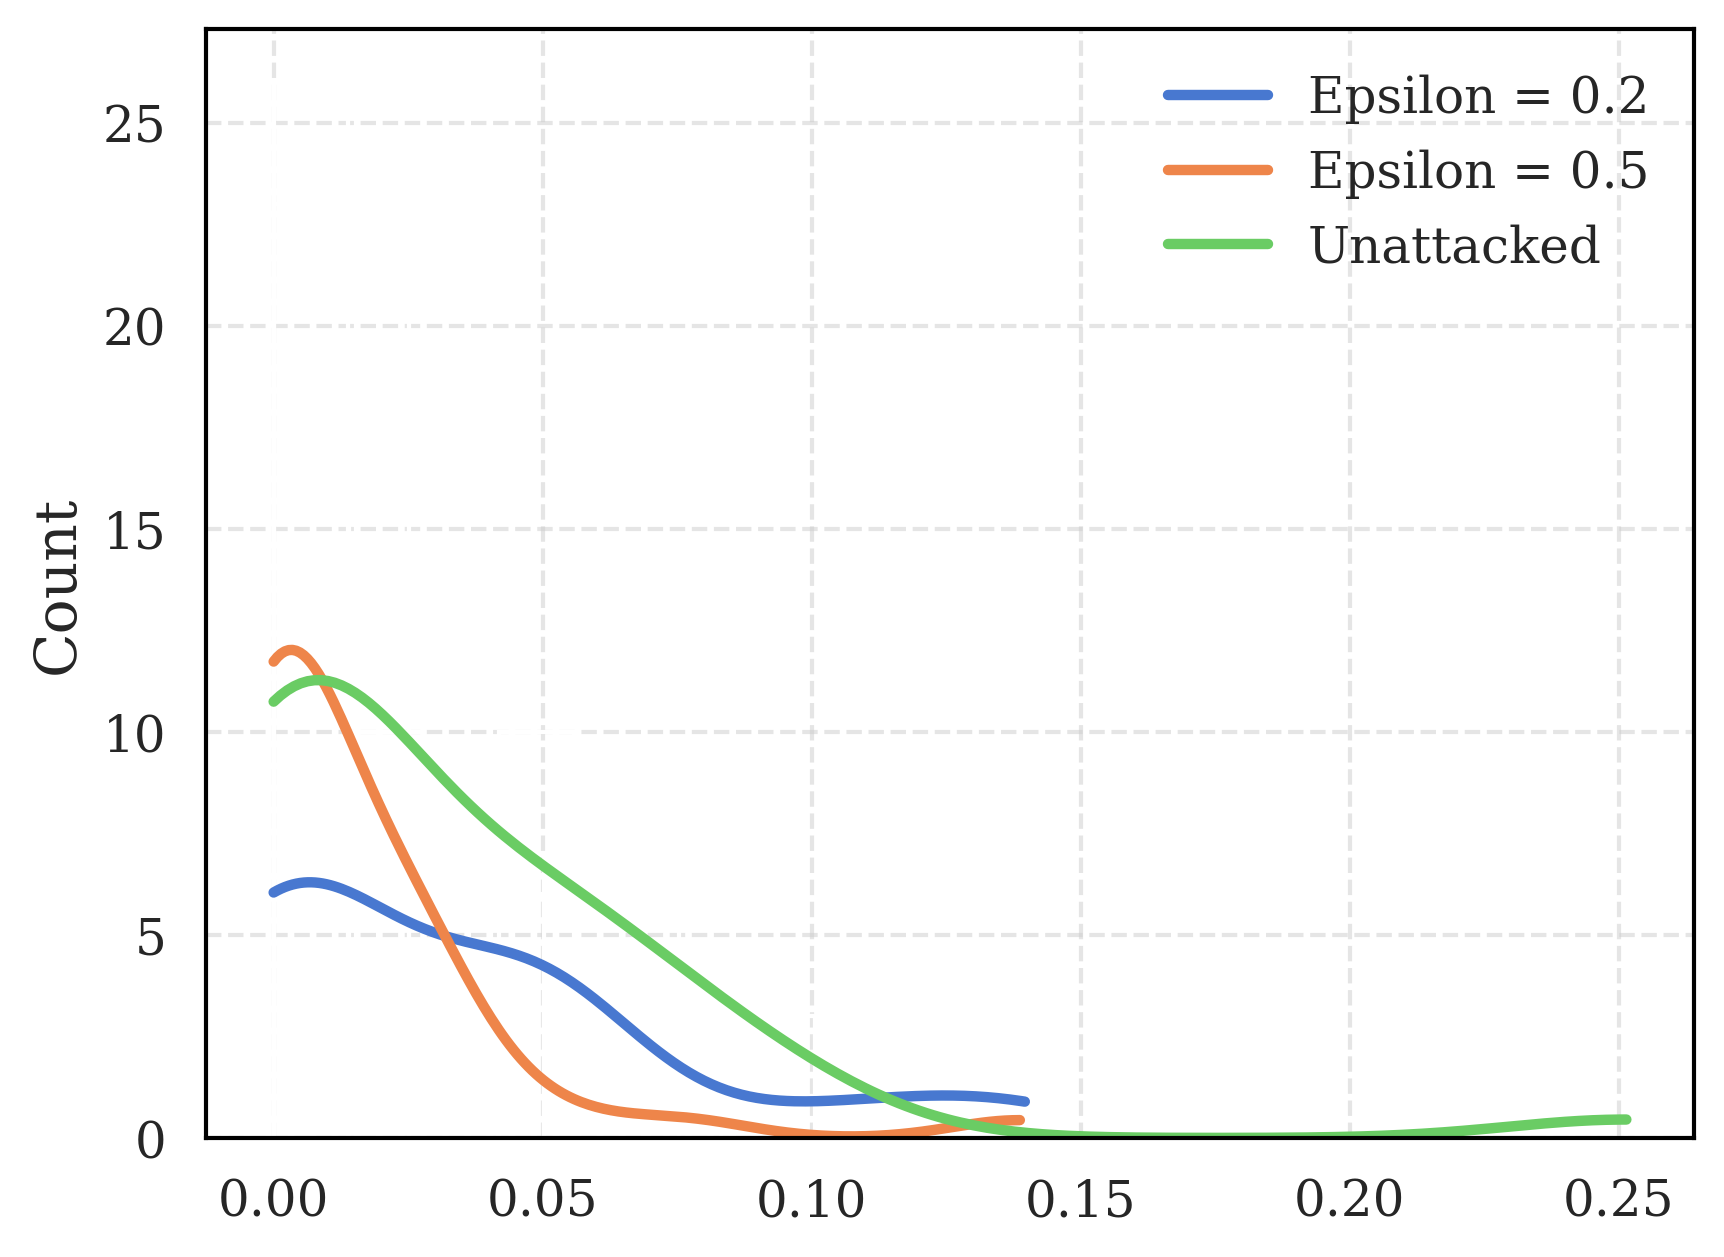

In [16]:
G = 0  # we want to lower the entropy of the predictive distribution

def process(x, eps):
    x = jax.numpy.array(x.reshape(1, -1))
    x_adv_values, loss_values, func_values = attack(x, modelVI, G, func=entropy, samples_per_iteration=1000, epsilon=eps, num_iterations=1000, learning_rate=0.01)
    preds = modelVI.sample_predictive_distribution_probs(jax.random.PRNGKey(0), x_adv_values[-1], 20)
    return entropy(x_adv_values[-1], preds)

epsilons = [.2, .5]
num_points = 40
for eps in epsilons:
    #entropies = Parallel(n_jobs=8)(delayed(process)(x, eps) for x in tqdm(X_test[:num_points]))
    entropies = [process(x, eps) for x in tqdm(X_notmnist[:num_points])]
    sns.histplot(jnp.array(entropies), kde=True, bins=10, alpha=0.)
    
unattacked_entropies = []
for x in tqdm(X_notmnist[:num_points]):
    x = jax.numpy.array(x.reshape(1, -1))
    preds = modelVI.sample_predictive_distribution_probs(jax.random.PRNGKey(0), x, 20)
    unattacked_entropies.append(entropy(x, preds))

sns.histplot(jnp.array(unattacked_entropies), kde=True, bins=10, alpha=0.)
legend = ['Epsilon = ' + str(eps) for eps in epsilons] + ['Unattacked']
plt.legend(legend)

## Distribution attacks

  0%|          | 0/40 [00:00<?, ?it/s]

Early stopping at iteration 12


  2%|▎         | 1/40 [00:05<03:17,  5.07s/it]

Early stopping at iteration 49


  5%|▌         | 2/40 [00:21<07:20, 11.59s/it]

Early stopping at iteration 12


  8%|▊         | 3/40 [00:26<05:20,  8.67s/it]

Early stopping at iteration 12


 10%|█         | 4/40 [00:30<04:13,  7.04s/it]

Early stopping at iteration 12


 12%|█▎        | 5/40 [00:35<03:39,  6.26s/it]

Early stopping at iteration 89


 15%|█▌        | 6/40 [01:04<07:51, 13.87s/it]

Early stopping at iteration 36


 18%|█▊        | 7/40 [01:27<09:19, 16.97s/it]

Early stopping at iteration 12


 20%|██        | 8/40 [01:32<06:55, 12.98s/it]

Early stopping at iteration 198


 22%|██▎       | 9/40 [02:45<16:25, 31.78s/it]

Early stopping at iteration 60


 25%|██▌       | 10/40 [03:06<14:12, 28.42s/it]

Early stopping at iteration 12


 30%|███       | 12/40 [05:34<27:12, 58.32s/it]

Early stopping at iteration 12


 32%|███▎      | 13/40 [05:42<19:21, 43.00s/it]

Early stopping at iteration 12


 35%|███▌      | 14/40 [05:47<13:39, 31.52s/it]

Early stopping at iteration 12


 38%|███▊      | 15/40 [05:52<09:48, 23.54s/it]

Early stopping at iteration 58


 40%|████      | 16/40 [06:16<09:27, 23.66s/it]

Early stopping at iteration 66


 42%|████▎     | 17/40 [06:37<08:47, 22.92s/it]

Early stopping at iteration 12


 48%|████▊     | 19/40 [09:10<19:53, 56.85s/it]

Early stopping at iteration 12


 50%|█████     | 20/40 [09:17<13:57, 41.88s/it]

Early stopping at iteration 119


 52%|█████▎    | 21/40 [10:04<13:45, 43.43s/it]

Early stopping at iteration 12


 55%|█████▌    | 22/40 [10:10<09:39, 32.17s/it]

Early stopping at iteration 84


 57%|█████▊    | 23/40 [10:37<08:38, 30.50s/it]

Early stopping at iteration 12


 60%|██████    | 24/40 [10:42<06:07, 22.94s/it]

Early stopping at iteration 186


 62%|██████▎   | 25/40 [11:47<08:53, 35.57s/it]

Early stopping at iteration 12


 65%|██████▌   | 26/40 [11:53<06:11, 26.57s/it]

Early stopping at iteration 218


 68%|██████▊   | 27/40 [13:05<08:42, 40.23s/it]

Early stopping at iteration 12


 70%|███████   | 28/40 [13:11<06:00, 30.01s/it]

Early stopping at iteration 12


 72%|███████▎  | 29/40 [13:17<04:08, 22.60s/it]

Early stopping at iteration 12


 75%|███████▌  | 30/40 [13:22<02:55, 17.55s/it]

Early stopping at iteration 89


 78%|███████▊  | 31/40 [13:54<03:16, 21.78s/it]

Early stopping at iteration 12


 80%|████████  | 32/40 [13:59<02:13, 16.75s/it]

Early stopping at iteration 86


 85%|████████▌ | 34/40 [16:46<05:35, 55.89s/it]

Early stopping at iteration 80


 88%|████████▊ | 35/40 [17:18<04:02, 48.53s/it]

Early stopping at iteration 31


 90%|█████████ | 36/40 [17:28<02:28, 37.16s/it]

Early stopping at iteration 12


 92%|█████████▎| 37/40 [17:33<01:22, 27.58s/it]

Early stopping at iteration 12


 98%|█████████▊| 39/40 [19:58<00:56, 56.57s/it]

Early stopping at iteration 12


  0%|          | 0/40 [00:00<?, ?it/s]

Early stopping at iteration 12


  2%|▎         | 1/40 [00:05<03:24,  5.23s/it]

Early stopping at iteration 52


  5%|▌         | 2/40 [00:24<08:40, 13.69s/it]

Early stopping at iteration 12


  8%|▊         | 3/40 [00:29<06:01,  9.78s/it]

Early stopping at iteration 12


 10%|█         | 4/40 [00:35<04:45,  7.92s/it]

Early stopping at iteration 12


 12%|█▎        | 5/40 [00:39<03:56,  6.76s/it]

Early stopping at iteration 98


 15%|█▌        | 6/40 [01:11<08:43, 15.39s/it]

Early stopping at iteration 36


 18%|█▊        | 7/40 [01:24<07:53, 14.33s/it]

Early stopping at iteration 12


 20%|██        | 8/40 [01:29<06:07, 11.48s/it]

Early stopping at iteration 57


 22%|██▎       | 9/40 [01:46<06:49, 13.20s/it]

Early stopping at iteration 67


 25%|██▌       | 10/40 [02:05<07:34, 15.16s/it]

Early stopping at iteration 12


 30%|███       | 12/40 [04:24<22:54, 49.07s/it]

Early stopping at iteration 12


 32%|███▎      | 13/40 [04:30<16:12, 36.03s/it]

Early stopping at iteration 12


 35%|███▌      | 14/40 [04:35<11:35, 26.77s/it]

Early stopping at iteration 12


 38%|███▊      | 15/40 [04:40<08:24, 20.17s/it]

Early stopping at iteration 65


 40%|████      | 16/40 [05:04<08:28, 21.18s/it]

Early stopping at iteration 73


 42%|████▎     | 17/40 [05:26<08:14, 21.50s/it]

Early stopping at iteration 12


 45%|████▌     | 18/40 [05:31<06:04, 16.57s/it]

Early stopping at iteration 69


 48%|████▊     | 19/40 [05:51<06:07, 17.49s/it]

Early stopping at iteration 12


 50%|█████     | 20/40 [05:56<04:33, 13.66s/it]

Early stopping at iteration 96


 52%|█████▎    | 21/40 [06:25<05:48, 18.35s/it]

Early stopping at iteration 12


 55%|█████▌    | 22/40 [06:29<04:15, 14.20s/it]

Early stopping at iteration 117


 57%|█████▊    | 23/40 [07:04<05:45, 20.32s/it]

Early stopping at iteration 12


 60%|██████    | 24/40 [07:08<04:08, 15.56s/it]

Early stopping at iteration 184


 62%|██████▎   | 25/40 [08:04<06:53, 27.59s/it]

Early stopping at iteration 12


 65%|██████▌   | 26/40 [08:09<04:53, 20.94s/it]

Early stopping at iteration 166


 68%|██████▊   | 27/40 [08:55<06:07, 28.28s/it]

Early stopping at iteration 12


 70%|███████   | 28/40 [09:00<04:16, 21.34s/it]

Early stopping at iteration 12


 72%|███████▎  | 29/40 [09:05<02:59, 16.35s/it]

Early stopping at iteration 12


 75%|███████▌  | 30/40 [09:09<02:08, 12.84s/it]

Early stopping at iteration 60


 78%|███████▊  | 31/40 [09:27<02:07, 14.17s/it]

Early stopping at iteration 12


 80%|████████  | 32/40 [09:31<01:30, 11.36s/it]

Early stopping at iteration 95


 82%|████████▎ | 33/40 [09:58<01:52, 16.03s/it]

Early stopping at iteration 61


 85%|████████▌ | 34/40 [10:16<01:38, 16.47s/it]

Early stopping at iteration 282


 88%|████████▊ | 35/40 [11:42<03:07, 37.50s/it]

Early stopping at iteration 38


 90%|█████████ | 36/40 [11:57<02:02, 30.62s/it]

Early stopping at iteration 12


 92%|█████████▎| 37/40 [12:02<01:08, 22.99s/it]

Early stopping at iteration 12


 95%|█████████▌| 38/40 [12:07<00:35, 17.63s/it]

Early stopping at iteration 74


 98%|█████████▊| 39/40 [12:31<00:19, 19.53s/it]

Early stopping at iteration 12


100%|██████████| 40/40 [00:28<00:00,  1.42it/s]


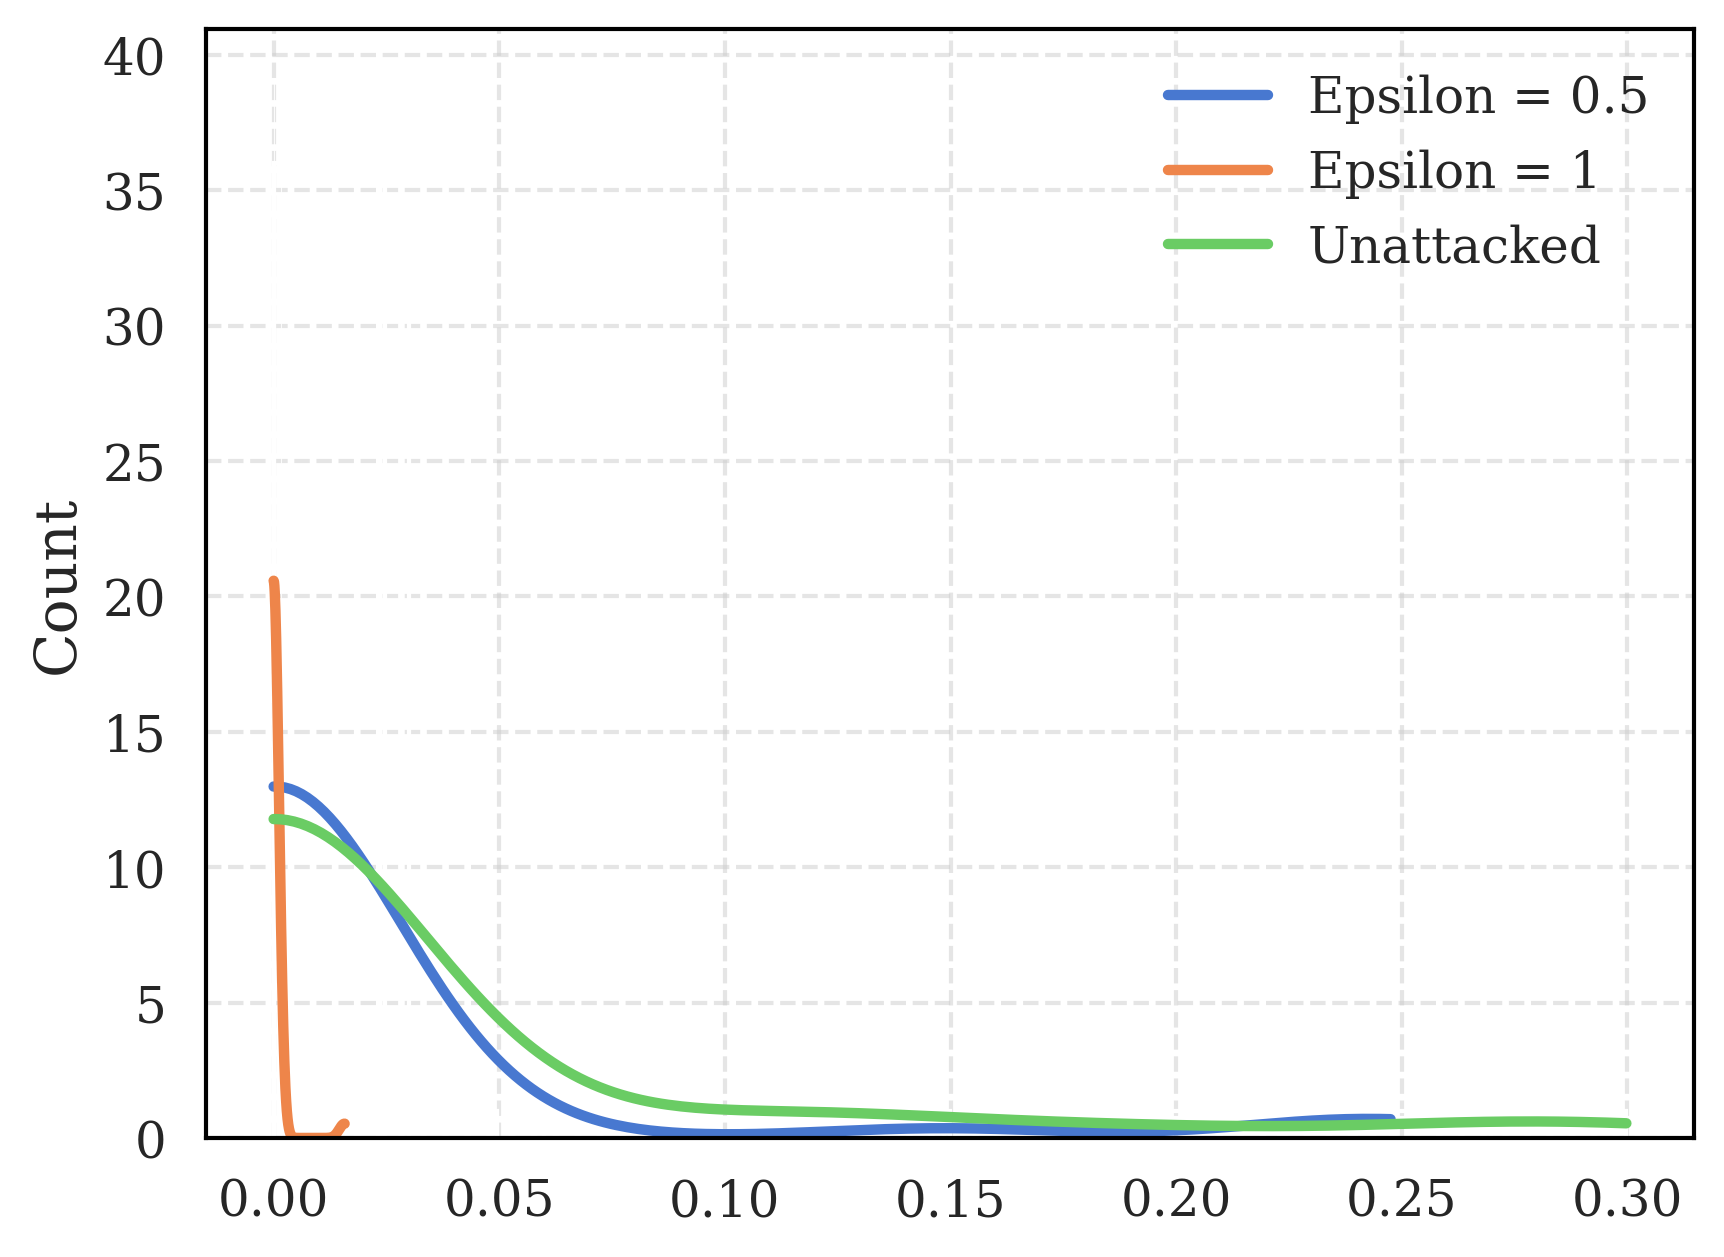

In [ ]:
# Y is a uniform distribution over 10 classes
obj_appd = numpyro.distributions.Categorical(jnp.ones(10) / 10)

def process(x, eps):
    x = jax.numpy.array(x.reshape(1, -1))
    x_adv, _ = mlmc_attack(modelVI, x, appd=obj_appd, epsilon=eps, n_iter=400, lr=0.01)  # TODO DIFFERENT LR???
    preds = modelVI.sample_predictive_distribution_probs(jax.random.PRNGKey(0), x_adv, 20)
    return entropy(x_adv, preds)

epsilons = [0.5, 1]
num_points = 40
for eps in epsilons:
    #entropies = Parallel(n_jobs=4)(delayed(process)(x, eps) for x in tqdm(X_test[:80]))
    entropies = [process(x, eps) for x in tqdm(X_test[:num_points])]
    sns.histplot(jnp.array(entropies), kde=True, bins=10, alpha=0.)
    
unattacked_entropies = []
for x in tqdm(X_test[:num_points]):
    x = jax.numpy.array(x.reshape(1, -1))
    preds = modelVI.sample_predictive_distribution_probs(jax.random.PRNGKey(0), x, 20)
    unattacked_entropies.append(entropy(x, preds))

sns.histplot(jnp.array(unattacked_entropies), kde=True, bins=10, alpha=0.)
legend = ['Epsilon = ' + str(eps) for eps in epsilons] + ['Unattacked']
plt.legend(legend)

In [16]:
def process(x, eps):
    x = jax.numpy.array(x.reshape(1, -1))
    pred = modelVI.sample_predictive_distribution(jax.random.PRNGKey(0), x, 1)  # so obj_appd is just 1 point mass on pred
    obj_appd = numpyro.distributions.Categorical(probs=jax.nn.one_hot(pred, 10))
    
    x_adv, _ = mlmc_attack(modelVI, x, appd=obj_appd, epsilon=eps, n_iter=400)
    preds = modelVI.sample_predictive_distribution_probs(jax.random.PRNGKey(0), x_adv, 20)
    return entropy(x_adv, preds)

epsilons = [0.5, 1]
num_points = 100
for eps in epsilons:
    #entropies = Parallel(n_jobs=4)(delayed(process)(x, eps) for x in tqdm(X_notmnist[:8]))  # TODO 80 points
    entropies = [process(x, eps) for x in tqdm(X_notmnist[:num_points])]
    sns.histplot(jnp.array(entropies), kde=True, bins=10, alpha=0.)

unattacked_entropies = []
for x in tqdm(X_notmnist[:num_points]):
    x = jax.numpy.array(x.reshape(1, -1))
    preds = modelVI.sample_predictive_distribution(jax.random.PRNGKey(0), x, 20)
    unattacked_entropies.append(entropy(x, preds))

sns.histplot(jnp.array(unattacked_entropies), kde=True, bins=10, alpha=0.)
legend = ['Epsilon = ' + str(eps) for eps in epsilons] + ['Unattacked']
plt.legend(legend)

  5%|▌         | 5/100 [12:21<3:55:46, 148.91s/it]